In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score

In [12]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Imoesi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Imoesi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Imoesi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Imoesi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [13]:
reddit_posts_df = pd.read_csv('combinedData.csv')
reddit_posts_df

features = ['selftext', 'title']
X = reddit_posts_df[features]
y = reddit_posts_df.subreddit

In [14]:
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

def clean_df(df):
    temp_X_train = [entry.lower() for entry in df]
    temp_X_train = [word_tokenize(entry) for entry in temp_X_train]
    
    df_to_return = pd.DataFrame()
    for index,entry in enumerate(temp_X_train):
        Final_words = []
        word_Lemmatized = WordNetLemmatizer()
        for word, tag in pos_tag(entry):
            if word not in stopwords.words('english') and word.isalpha():
                word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
                Final_words.append(word_Final)
        df_to_return.loc[index,'data'] = str(Final_words)
        
    indexes_to_drop = df_to_return[df_to_return.data == '[]'].index
    
    return df_to_return, indexes_to_drop

def merge_arrays(arr1, arr2):
    set_to_return = set()
    for ele in arr1:
        set_to_return.add(ele)
    for ele in arr2:
        set_to_return.add(ele) 
    return set_to_return

def remove_index(df, index_list):
    for i in index_list:
        df = df.drop(i)
    return df

## Pre processing data

In [15]:
X_post_text , text_index = clean_df(X.selftext.values.astype('U'))
X_post_title, title_index = clean_df(X.title)
indices_to_remove_from_data = merge_arrays(text_index, title_index)
cleaned_text_df = remove_index(X_post_text, indices_to_remove_from_data)
cleaned_title_df = remove_index(X_post_title, indices_to_remove_from_data)
y_df = pd.DataFrame()
for index, data in enumerate(y):
    y_df.loc[index,'data'] = data
convert_dict = {'data': int}
y_df = y_df.astype(convert_dict)
cleaned_Y_df = remove_index(y_df, indices_to_remove_from_data)

vectorizer1 = TfidfVectorizer(norm='l2', ngram_range=(1,3))
Xtitle = vectorizer1.fit_transform(cleaned_title_df['data'])
vectorizer2 = TfidfVectorizer(norm='l2', ngram_range=(1,3))
Xtext = vectorizer2.fit_transform(cleaned_text_df['data'])

X_title_tfidf = pd.DataFrame(Xtitle.todense(), columns=[x+'_title' for x in vectorizer1.get_feature_names()])
print(X_title_tfidf.shape)
X_text_tfidf = pd.DataFrame(Xtext.todense(), columns=[x+'_text' for x in vectorizer2.get_feature_names()])
X_text_tfidf.shape

tfidf_reddit_posts = pd.concat([X_title_tfidf, X_text_tfidf], axis=1)

X_train1, X_test1, y_train1, y_test1 = model_selection.train_test_split(tfidf_reddit_posts,cleaned_Y_df,test_size=0.3)

C:\Users\Imoesi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(3337, 26212)


## Model Training

In [16]:
SVM = svm.SVC(C=10, kernel='linear')
SVM.fit(X_train1,y_train1.data)
predictions_SVM = SVM.predict(X_test1)
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_test1.data)*100)
f1_score(y_test1.data, predictions_SVM)

SVM Accuracy Score ->  61.876247504990026


0.6094069529652352

C = 0.1
0.6693289904473928
C = 1
0.5997547057261599
C = 10


C:\Users\Imoesi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
4 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Imoesi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Imoesi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py", line 238, in fit
    X_var = (X.multiply(X)).mean() - (X.mean()) ** 2 if sparse else X.var()
  File "C:\Users\Imoesi\AppData\Local\Programs\Python

nan
C = 100


C:\Users\Imoesi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Imoesi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Imoesi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py", line 238, in fit
    X_var = (X.multiply(X)).mean() - (X.mean()) ** 2 if sparse else X.var()
  File "C:\Users\Imoesi\AppData\Local\Programs\Python

nan
C = 1000


C:\Users\Imoesi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Imoesi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Imoesi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py", line 238, in fit
    X_var = (X.multiply(X)).mean() - (X.mean()) ** 2 if sparse else X.var()
  File "C:\Users\Imoesi\AppData\Local\Programs\Python

nan


C:\Users\Imoesi\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\Imoesi\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


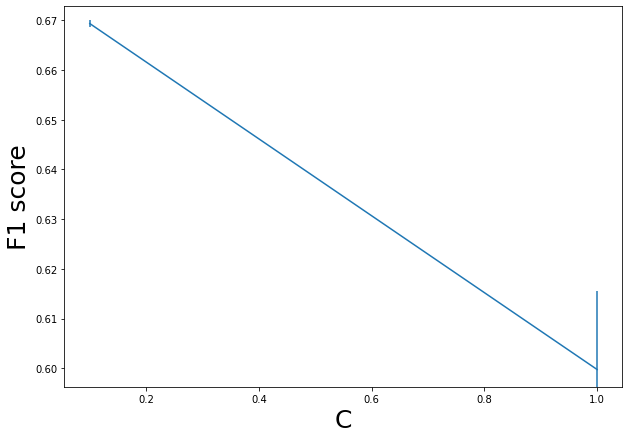

In [17]:
C_range = [0.1, 1, 10, 100, 1000]
mean_f1=[];std_error=[]
for c in C_range:
    print('C = ' + str(c))
    SVM = svm.SVC(C=c, kernel='linear')
    scores = cross_val_score(SVM, X_train1, y_train1.data, cv=5, scoring='f1')
    mean_f1.append(np.array(scores).mean())
    std_error.append(np.array(scores).std())
    print(np.array(scores).mean())
plt.errorbar(C_range, mean_f1, yerr=std_error)
plt.xlabel('C', fontsize=25); plt.ylabel('F1 score', fontsize=25)
plt.gcf().set_size_inches((10,7))
plt.show()